In [72]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

Populating the interactive namespace from numpy and matplotlib


In [73]:
import calc_enrich
reload(calc_enrich)
from calc_enrich import calc_del_U
from calc_enrich import stages_per_cascade
from calc_enrich import N_product_by_alpha
from calc_enrich import N_waste_by_alpha
from calc_enrich import machines_per_enr_stage
from calc_enrich import machines_per_strip_stage

For a type of centrifuge and some cascade guidelines, design the cascade
Start at nat U, enrich to 3.5%, 
Use IR-1 machines (Inst Sci Intl Security, IAEA 2014)

In [74]:
# centrifuge params 
omega = 64000
d = 0.1  # m 
Z = 2.0   # m
F_m_hrs = 70 # grams/hr  
T = 320.0   # K
cut = 0.5
eff = 1.0 # centrifuge efficiency

# cascade params
Nfc = 0.0071
Npc = 0.035
Nwc = 0.001
Fc_month = 739 #kg/month

#unit conversions
v_a = omega * (d/2.0)
F_m = F_m_hrs/(60*60*1000.0)
Fc = Fc_month/(30.4*24*60*60)

# Comparison numbers (not needed for calculations)
del_U_th_yr = 1.1 #swu/yr
del_U_obs_yr = 0.71 #Swu/yr
del_U_th = del_U_th_yr/(365.25*24*60*60) #kgSWU/sec
del_U_obs = del_U_obs_yr/(365.25*24*60*60)

Pc_month = 77 #kg/month


In [75]:
alpha, del_U, del_U_yr = calc_del_U(v_a, Z, d, F_m, T, cut, eff)
n_enrich_s, n_strip_s= stages_per_cascade(alpha, Nfc, Npc, Nwc)
print "number of enrich, strip stages is ", n_enrich_s, n_strip_s
#print del_U*60*60*24*365.25, del_U_th

L_F=  2.0
Z_p=   1.2
number of enrich, strip stages is  3.33915008499 4.0434067006


In [80]:
n_stage_en = int(round(n_enrich_s)) + 1  # add one for extra partial stage lost in rounding
epsilon = alpha - 1.0
# starting feed stages and enrichment are starting cascade values
Nfs = Nfc
Fs = Fc
print "stage, #mach, Feed,   Product,    N_F,     N_P"
# http://books.sipri.org/files/books/SIPRI83Krass/SIPRI83Krass05.pdf
# eqn 5.8 says Total # stages is N_strip + N_enrich + 1  (presumably the feed stage)
enrich_stages = []
for i in range(0, n_stage_en):  
    Nps = N_product_by_alpha(alpha, Nfs)
    n_mach, Ps = machines_per_enr_stage(alpha, del_U, Nfs, Nps, Fs)
    enrich_stages.append([i, n_mach])
    if (i == 1):
        W_enr1 = Fs - Ps
        Nw_enr1 = (Fs*Nfs - Ps*Nps)/W_enr1
    print i, n_mach, Fs, Ps,  Nfs, Nps
    Nfs = Nps
    Fs = Ps

print "product of cascade (kg/mon)" , Fs*60*60*24*30
enrich_stages

stage, #mach, Feed,   Product,    N_F,     N_P
0 41.1072959387 0.000281356603314 0.000141164003847 0.0071 0.0105162654179
1 20.6246109517 0.000141164003847 7.09429461565e-05 0.0105162654179 0.0155505706868
2 10.3650408346 7.09429461565e-05 3.57397048095e-05 0.0155505706868 0.0229390081722
3 5.22171011827 3.57397048095e-05 1.80691858614e-05 0.0229390081722 0.0337176313156
product of cascade (kg/mon) 46.8353297529


[[0, 41.107295938710415],
 [1, 20.624610951681909],
 [2, 10.365040834556005],
 [3, 5.2217101182688905]]

In [77]:
n_stage_str = int(round(n_strip_s)) + 1  # add one for extra partial stage lost in rounding
epsilon = alpha - 1.0

F_strip = W_enr1
Nf_strip = Nw_enr1

print "stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip"
strip_stages = []
for i in range(1, n_stage_str):  
    Nw_strip = N_waste_by_alpha(alpha, Nf_strip)
    n_mach_s, W_strip = machines_per_strip_stage(alpha, del_U, Nf_strip, Nw_strip, F_strip)
    strip_stages.append([-1*i,n_mach_s])
    print i, n_mach_s, F_strip, W_strip, Nf_strip, Nw_strip
    F_strip = W_strip
    Nf_strip = Nw_strip

strip_stages

stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip
1 10.2595701171 7.02210576906e-05 5.20912930917e-05 0.00543020634427 0.00366006303877
2 7.61074087378 5.20912930917e-05 3.86647144659e-05 0.00366006303877 0.00246552210614
3 5.64906542521 3.86647144659e-05 2.87100785687e-05 0.00246552210614 0.00166019587887
4 4.19465433633 2.87100785687e-05 2.13239896068e-05 0.00166019587887 0.00111762280419


[[-1, 10.259570117125904],
 [-2, 7.6107408737804239],
 [-3, 5.6490654252061079],
 [-4, 4.1946543363302311]]

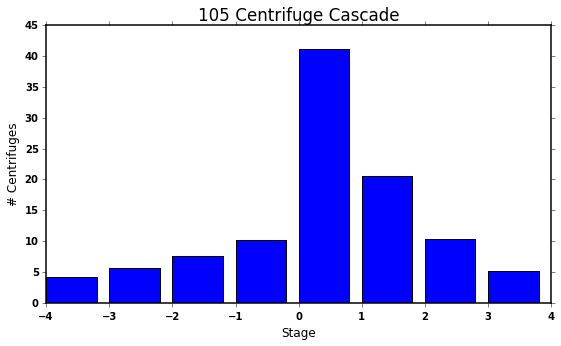

In [88]:
all_stages = np.array(strip_stages+enrich_stages)
n_centrifuges = np.sum(all_stages[:,1], axis=0)

bar_width = 0.8
bar_res = plt.bar(all_stages[:,0], all_stages[:,1], bar_width)


plt.xlabel('Stage')
plt.ylabel('# Centrifuges')
plt.title(str(int(n_centrifuges)) + " Centrifuge Cascade")
plt.legend()

plt.tight_layout()
plt.show()
